# News - Oriented Stock Price Trend Prediction - (NLP & Stacked LSTM)

### Problem Statement:

 - The prediction of stock prices in the market has always been an important task. However, due to the market volatility, it is difficult to make the correct prediction solely based on historical stock data. Therefore in this notebook, with the analysis of daily news’ impact on stock markets, will identify some key features that could be useful in stock price prediction and propose a deep learning model to capture the dynamics of stock price trend with rich news textual information.
 
### Dataset:

 - The dataset working on is a combination of Reddit news and the Dow Jones Industrial Average (DJIA) stock price from 2008 to 2016. 
     - The news dataset contains the top 25 news on Reddit of each day from 2008 to 2016.
     - The DJIA contains the core stock market information for each trading day such as Open, Close, and Volume. The label of the dataset represents whether the stock price is increase (labeled as 1) or decrease (labeled as 0) on that day. The total number of days in the dataset is 1989.

# Importing Libraries and Packages

In [ ]:
# !pip install -q wordcloud
# !pip install gensim
# !pip install vaderSentiment

# import nltk

# nltk.download()
# nltk.download("punkt")

# # download nltk if not installed previously
# nltk.download('vader_lexicon')

# # !pip install --upgrade tensorflow
# # pip install Keras
# # pip install tensorflow==2.1.0

In [ ]:
# importing libraries
import warnings
warnings.filterwarnings('ignore')

import math
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from keras.layers import Dense, LSTM, Dropout, Dense, Activation

import nltk
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *

import wordcloud

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger') 
nltk.download('vader_lexicon')

from sklearn import preprocessing, metrics
from sklearn.preprocessing import MinMaxScaler

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Getting the Dataset

In [ ]:
stock = pd.read_csv("upload_DJIA_table.csv")
stock.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,7/1/2016,17924.24023,18002.38086,17916.91016,17949.36914,82160000,17949.36914
1,6/30/2016,17712.75977,17930.60938,17711.80078,17929.99023,133030000,17929.99023
2,6/29/2016,17456.01953,17704.50977,17456.01953,17694.67969,106380000,17694.67969
3,6/28/2016,17190.50977,17409.72070,17190.50977,17409.72070,112190000,17409.72070
4,6/27/2016,17355.21094,17355.21094,17063.08008,17140.24023,138740000,17140.24023


In [ ]:
Reddit = pd.read_csv("/content/RedditNews.csv")
Reddit.head()

,Date,News
0,2016-07-01,A 117-year-old woman in Mexico City finally re...
1,2016-07-01,IMF chief backs Athens as permanent Olympic host
2,2016-07-01,"The president of France says if Brexit won, so..."
3,2016-07-01,British Man Who Must Give Police 24 Hours' Not...
4,2016-07-01,100+ Nobel laureates urge Greenpeace to stop o...


In [ ]:
Top_Headlines = pd.read_csv("Combined_News_DJIA.csv")
Top_Headlines.head()

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,8/8/2008,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",...,b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
1,8/11/2008,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."
2,8/12/2008,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...",...,b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man..."
3,8/13/2008,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who killed Reuters cam...,b'Britain\'s policy of being tough on drugs is...,b'Body of 14 year old found in trunk; Latest (...,b'China has moved 10 *million* quake survivors...,"b""Bush announces Operation Get All Up In Russi...",b'Russian forces sink Georgian ships ',...,b'Elephants extinct by 2020?',b'US humanitarian missions soon in Georgia - i...,"b""Georgia's DDOS came from US sources""","b'Russian convoy heads into Georgia, violating...",b'Israeli defence minister: US against strike ...,b'Gorbachev: We Had No Choice',b'Witness: Russian forces head towards Tbilisi...,b' Quarter of Russians blame U.S. for conflict...,b'Georgian president says US military will ta...,b'2006: Nobel laureate Aleksander Solzhenitsyn...
4,8/14/2008,1,b'All the experts admit that we should legalis...,b'War in South Osetia - 89 pictures made by a ...,b'Swedish wrestler Ara Abrahamian throws away ...,b'Russia exaggerated the death toll in South O...,b'Missile That Killed 9 Inside Pakistan May Ha...,"b""Rushdie Condemns Random House's Refusal to P...",b'Poland and US agree to mis

In [ ]:
data=Top_Headlines.iloc[:,2:27]
data.replace("[^a-zA-Z]"," ",regex=True, inplace=True)

# Renaming column names for ease of access
list1= [i for i in range(25)]
new_Index=[str(i) for i in list1]
data.columns= new_Index
data.head(5)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,b Georgia downs two Russian warplanes as cou...,b BREAKING Musharraf to be impeached,b Russia Today Columns of troops roll into So...,b Russian tanks are moving towards the capital...,b Afghan children raped with impunity U N ...,b Russian tanks have entered South Ossetia...,b Breaking Georgia invades South Ossetia Rus...,b The enemy combatent trials are nothing but...,b Georgian troops retreat from S Osettain cap...,b Did the U S Prep Georgia for War with Russia,...,b Georgia Invades South Ossetia if Russia ge...,b Al Qaeda Faces Islamist Backlash,b Condoleezza Rice The US would not act to p...,b This is a busy day The European Union has ...,b Georgia will withdraw soldiers from Ir...,b Why the Pentagon Thinks Attacking Iran is a ...,b Caucasus in crisis Georgia invades South Os...,b Indian shoe manufactory And again in a se...,b Visitors Suffering from Mental Illnesses Ban...,b No Help for Mexico s Kidnapping Surge
1,b Why wont America and Nato help us If they w...,b Bush puts foot down on Georgian conflict,b Jewish Georgian minister Thanks to Israeli ...,b Georgian army flees in disarray as Russians ...,b Olympic opening ceremony fireworks faked,b What were the Mossad with fraudulent New Zea...,b Russia angered by Israeli military sale to G...,b An American citizen living in S Ossetia blam...,b Welcome To World War IV Now In High Definit...,b Georgia s move a mistake of monumental prop...,...,b Israel and the US behind the Georgian aggres...,b Do not believe TV neither Russian nor Geor...,b Riots are still going on in Montreal Canada...,b China to overtake US as largest manufacturer,b War in South Ossetia PICS,b Israeli Physicians Group Condemns State Tort...,b Russia has just beaten the United States ov...,b Perhaps the question about the Georgia R...,b Russia is so much better at war,b So this is what it s come to trading sex fo...
2,b Remember that adorable year old who sang a...,b Russia ends Georgia operation,b If we had no sexual harassment we would hav...,b Al Qa eda is losing support in Iraq because ...,b Ceasefire in Georgia Putin Outmaneuvers the...,b Why Microsoft and Intel tried to kill the XO...,b Stratfor The Russo Georgian War and the Bal...,b I m Trying to Get a Sense of This Whole Geor...,b The US military was surprised by the timing ...,b U S Beats War Drum as Iran Dumps the Dollar,...,b U S troops still in Georgia did you know t...,b Why Russias response to Georgia was right,b Gorbachev accuses U S of making a serious ...,b Russia Georgia and NATO Cold War Two,b Remember that adorable year old who led y...,b War in Georgia The Israeli connection,b All signs point to the US encouraging Georgi...,b Christopher King argues that the US and NATO...,b America The New Mexico,b BBC NEWS Asia Pacific Extinction by man...
3,b U S refuses Israel weapons to attack Iran ...,b When the president ordered to attack Tskhinv...,b Israel clears troops who killed Reuters cam...,b Britain s policy of being tough on drugs is...,b Body of year old found in trunk Latest ...,b China has moved million quake survivors...,b Bush announces Operation Get All Up In Russi...,b Russian forces sink Georgian ships,b The commander of a Navy air reconnaissance s...,b of CNN readers Russia s actions in Geor...,...,b Elephants extinct by,b US humanitarian missions soon in Georgia i...,b Georgia s DDOS came from US sources,b Russian convoy heads into Georgia violating...,b Israeli defence minister US against strike ...,b Gorbachev We Had No Choice,b Witness Russian forces head towards Tbilisi...,b Quarter of Russians blame U S for conflict...,b Georgian president says US military will ta...,b Nobel laureate Aleksander Solzhenitsyn...
4,b All the experts admit that we should legalis...,b War in South Osetia pictures made by a ...,b Swedish wrestler Ara Abrahamian throws away ...,b Russia exaggerated the death toll in South O...,b Missile That Killed Inside Pakistan May Ha...,b Rushdie Cond

In [ ]:
# Convertng headlines to lower case
for index in new_Index:
    data[index]=data[index].str.lower()
data.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,b georgia downs two russian warplanes as cou...,b breaking musharraf to be impeached,b russia today columns of troops roll into so...,b russian tanks are moving towards the capital...,b afghan children raped with impunity u n ...,b russian tanks have entered south ossetia...,b breaking georgia invades south ossetia rus...,b the enemy combatent trials are nothing but...,b georgian troops retreat from s osettain cap...,b did the u s prep georgia for war with russia,...,b georgia invades south ossetia if russia ge...,b al qaeda faces islamist backlash,b condoleezza rice the us would not act to p...,b this is a busy day the european union has ...,b georgia will withdraw soldiers from ir...,b why the pentagon thinks attacking iran is a ...,b caucasus in crisis georgia invades south os...,b indian shoe manufactory and again in a se...,b visitors suffering from mental illnesses ban...,b no help for mexico s kidnapping surge
1,b why wont america and nato help us if they w...,b bush puts foot down on georgian conflict,b jewish georgian minister thanks to israeli ...,b georgian army flees in disarray as russians ...,b olympic opening ceremony fireworks faked,b what were the mossad with fraudulent new zea...,b russia angered by israeli military sale to g...,b an american citizen living in s ossetia blam...,b welcome to world war iv now in high definit...,b georgia s move a mistake of monumental prop...,...,b israel and the us behind the georgian aggres...,b do not believe tv neither russian nor geor...,b riots are still going on in montreal canada...,b china to overtake us as largest manufacturer,b war in south ossetia pics,b israeli physicians group condemns state tort...,b russia has just beaten the united states ov...,b perhaps the question about the georgia r...,b russia is so much better at war,b so this is what it s come to trading sex fo...
2,b remember that adorable year old who sang a...,b russia ends georgia operation,b if we had no sexual harassment we would hav...,b al qa eda is losing support in iraq because ...,b ceasefire in georgia putin outmaneuvers the...,b why microsoft and intel tried to kill the xo...,b stratfor the russo georgian war and the bal...,b i m trying to get a sense of this whole geor...,b the us military was surprised by the timing ...,b u s beats war drum as iran dumps the dollar,...,b u s troops still in georgia did you know t...,b why russias response to georgia was right,b gorbachev accuses u s of making a serious ...,b russia georgia and nato cold war two,b remember that adorable year old who led y...,b war in georgia the israeli connection,b all signs point to the us encouraging georgi...,b christopher king argues that the us and nato...,b america the new mexico,b bbc news asia pacific extinction by man...
3,b u s refuses israel weapons to attack iran ...,b when the president ordered to attack tskhinv...,b israel clears troops who killed reuters cam...,b britain s policy of being tough on drugs is...,b body of year old found in trunk latest ...,b china has moved million quake survivors...,b bush announces operation get all up in russi...,b russian forces sink georgian ships,b the commander of a navy air reconnaissance s...,b of cnn readers russia s actions in geor...,...,b elephants extinct by,b us humanitarian missions soon in georgia i...,b georgia s ddos came from us sources,b russian convoy heads into georgia violating...,b israeli defence minister us against strike ...,b gorbachev we had no choice,b witness russian forces head towards tbilisi...,b quarter of russians blame u s for conflict...,b georgian president says us military will ta...,b nobel laureate aleksander solzhenitsyn...
4,b all the experts admit that we should legalis...,b war in south osetia pictures made by a ...,b swedish wrestler ara abrahamian throws away ...,b russia exaggerated the death toll in south o...,b missile that killed inside pakistan may ha...,b rushdie cond

In [ ]:
' '.join(str(x) for x in data.iloc[1,0:25])

'b why wont america and nato help us  if they wont help us now  why did we help them in iraq   b bush puts foot down on georgian conflict  b jewish georgian minister  thanks to israeli training  we re fending off russia   b georgian army flees in disarray as russians advance   gori abandoned to russia without a shot fired  b olympic opening ceremony fireworks  faked   b what were the mossad with fraudulent new zealand passports doing in iraq   b russia angered by israeli military sale to georgia  b an american citizen living in s ossetia blames u s  and georgian leaders for the genocide of innocent people  b welcome to world war iv  now in high definition   b georgia s move  a mistake of monumental proportions   b russia presses deeper into georgia  u s  says regime change is goal  b abhinav bindra wins first ever individual olympic gold medal for india  b  u s  ship heads for arctic to define territory  b drivers in a jerusalem taxi station threaten to quit rather than work for their 

In [ ]:
headlines = []
for row in range(0,len(data.index)):
    headlines.append(' '.join(str(x) for x in data.iloc[row,0:25]))

In [ ]:
headlines[0]

'b georgia  downs two russian warplanes  as countries move to brink of war  b breaking  musharraf to be impeached   b russia today  columns of troops roll into south ossetia  footage from fighting  youtube   b russian tanks are moving towards the capital of south ossetia  which has reportedly been completely destroyed by georgian artillery fire  b afghan children raped with  impunity   u n  official says   this is sick  a three year old was raped and they do nothing  b     russian tanks have entered south ossetia whilst georgia shoots down two russian jets   b breaking  georgia invades south ossetia  russia warned it would intervene on so s side  b the  enemy combatent  trials are nothing but a sham  salim haman has been sentenced to       years  but will be kept longer anyway just because they feel like it   b georgian troops retreat from s  osettain capital  presumably leaving several hundred people killed   video   b did the u s  prep georgia for war with russia   b rice gives green

In [ ]:
Top_Headlines["headlines"] = ""

In [ ]:
Top_Headlines.head(1)

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25,headlines
0,8/8/2008,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge""",


In [ ]:
for i in range(len(headlines)):
    Top_Headlines["headlines"][i] = headlines[i]
    
Top_Headlines.head()

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25,headlines
0,8/8/2008,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge""",b georgia downs two russian warplanes as cou...
1,8/11/2008,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo...",b why wont america and nato help us if they w...
2,8/12/2008,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...",...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man...",b remember that adorable year old who sang a...
3,8/13/2008,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who killed Reuters cam...,b'Britain\'s policy of being tough on drugs is...,b'Body of 14 year old found in trunk; Latest (...,b'China has moved 10 *million* quake survivors...,"b""Bush announces Operation Get All Up In Russi...",b'Russian forces sink Georgian ships ',...,b'US humanitarian missions soon in Georgia - i...,"b""Georgia's DDOS came from US sources""","b'Russian convoy heads into Georgia, violating...",b'Israeli defence minister: US against strike ...,b'Gorbachev: We Had No Choice',b'Witness: Russian forces head towards Tbilisi...,b' Quarter of Russians blame U.S. for conflict...,b'Georgian president says US military will ta...,b'2006: Nobel laureate Aleksander Solzhenitsyn...,b u s refuses israel weapons to attack iran ...
4,8/14/2008,1,b'All the experts admit that we should legalis...,b'War in South Osetia - 89 pictures made by a ...,b'Swedish wrestler Ara Abrahamian throws away ...,b'Russia exaggerated the death toll in South O...,b'Missile That Killed 9 Inside Pakistan May Ha...,"b""Rushdie Condemns Random House's Refusal to P...",b'Poland an

In [ ]:
Top_Headlines=Top_Headlines.drop(['Top1','Top2','Top3','Top4','Top5','Top6','Top7','Top8','Top9','Top10','Top11','Top12','Top13', 
             'Top14','Top15','Top16','Top17','Top18','Top19','Top20','Top21','Top22','Top23','Top24','Top25'],axis=1)

In [ ]:
mergedDf = stock.merge(Top_Headlines)
mergedDf.head()

,Date,Open,High,Low,Close,Volume,Adj Close,Label,headlines
0,7/1/2016,17924.24023,18002.38086,17916.91016,17949.36914,82160000,17949.36914,1,a year old woman in mexico city finally re...
1,6/30/2016,17712.75977,17930.60938,17711.80078,17929.99023,133030000,17929.99023,1,jamaica proposes marijuana dispensers for tour...
2,6/29/2016,17456.01953,17704.50977,17456.01953,17694.67969,106380000,17694.67969,1,explosion at airport in istanbul yemeni former...
3,6/28/2016,17190.50977,17409.72070,17190.50977,17409.72070,112190000,17409.72070,1,scientists to australia if you want to ...
4,6/27/2016,17355.21094,17355.21094,17063.08008,17140.24023,138740000,17140.24023,0,barclays and rbs shares suspended from trading...


### Feature Engineering

In [ ]:
# coverting the datatype of column 'Date' from type object to type 'datetime'
mergedDf['Date'] = pd.to_datetime(mergedDf['Date']).dt.normalize()

In [ ]:
mergedDf

,Date,Open,High,Low,Close,Volume,Adj Close,Label,headlines
0,2016-07-01,17924.24023,18002.38086,17916.91016,17949.36914,82160000,17949.36914,1,a year old woman in mexico city finally re...
1,2016-06-30,17712.75977,17930.60938,17711.80078,17929.99023,133030000,17929.99023,1,jamaica proposes marijuana dispensers for tour...
2,2016-06-29,17456.01953,17704.50977,17456.01953,17694.67969,106380000,17694.67969,1,explosion at airport in istanbul yemeni former...
3,2016-06-28,17190.50977,17409.72070,17190.50977,17409.72070,112190000,17409.72070,1,scientists to australia if you want to ...
4,2016-06-27,17355.21094,17355.21094,17063.08008,17140.24023,138740000,17140.24023,0,barclays and rbs shares suspended from trading...
...,...,...,...,...,...,...,...,...,...
1984,2008-08-14,11532.07031,11718.28027,11450.88965,11615.92969,159790000,11615.92969,1,b all the experts admit that we should legalis...
1985,2008-08-13,11632.80957,11633.78027,11453.33984,11532.95996,182550000,11532.95996,0,b u s refuses israel weapons to attack iran ...
1986,2008-08-12,11781.70020,11782.34961,11601.51953,11642.46973,173590000,11642.46973,0,b remember that adorable year old who sang a...
1987,2008-08-11,11729.66992,11867.11035,11675.53027,11782.34961,183190000,11782.34961,1,b why wont america and nato help us if they w...


In [ ]:
#DROP - Adj Close column as it is similer with Close Column
#DROP - Label Column as on what basis label is provided is not mentioned and this can effect further in analysis
mergedDf=mergedDf.drop(['Adj Close'],axis=1)
mergedDf=mergedDf.drop(['Label'],axis=1)


# filtering the important columns required
mergedDf = mergedDf.filter(['Date', 'Close', 'Open', 'High', 'Low', 'Volume','headlines'])

# setting column 'Date' as the index column


# sorting the data according to the index i.e 'Date'


In [ ]:
mergedDf.set_index('Date', inplace= True)

mergedDf = mergedDf.sort_index(ascending=True, axis=0)

mergedDf

,Close,Open,High,Low,Volume,headlines
Date,,,,,,
2008-08-08,11734.32031,11432.08984,11759.95996,11388.04004,212830000,b georgia downs two russian warplanes as cou...
2008-08-11,11782.34961,11729.66992,11867.11035,11675.53027,183190000,b why wont america and nato help us if they w...
2008-08-12,11642.46973,11781.70020,11782.34961,11601.51953,173590000,b remember that adorable year old who sang a...
2008-08-13,11532.95996,11632.80957,11633.78027,11453.33984,182550000,b u s refuses israel weapons to attack iran ...
2008-08-14,11615.92969,11532.07031,11718.28027,11450.88965,159790000,b all the experts admit that we should legalis...
...,...,...,...,...,...,...
2016-06-27,17140.24023,17355.21094,17355.21094,17063.08008,138740000,barclays and rbs shares suspended from trading...
2016-06-28,17409.72070,17190.50977,17409.72070,17190.50977,112190000,scientists to australia if you want to ...
2016-06-29,17694.67969,17456.01953,17704.50977,17456.01953,106380000,explosion at airport in istanbul yemeni former...


In [ ]:
# dropping duplicates
mergedDf = mergedDf.drop_duplicates()

# Calculating Sentiment Polarity and Subjectivity

 - The subjectivity shows how subjective or objective a statement is.

 - The polarity shows how positive/negative the statement is, a value equal to 1 means the statement is positive, a value equal to 0 means the statement is neutral and a value of -1 means the statement is negative.

In [ ]:
from textblob import TextBlob     # for performing NLP Functions i.e detection of Polarity and Subjectivity

polarity=[]     #list that contains polarity of tweets
subjectivity=[]    ##list that contains subjectivity of tweets

for i in mergedDf.headlines.values:
    try:
        analysis = TextBlob(i) # [i] records to the first data in dataset
        polarity.append(analysis.sentiment.polarity)
        subjectivity.append(analysis.sentiment.subjectivity)
        
    except:
        polarity.append(0)
        subjectivity.append(0)
        

        
# adding sentiment polarity and subjectivity column to dataframe

mergedDf['polarity'] = polarity
mergedDf['subjectivity'] = subjectivity
mergedDf.head()

,Close,Open,High,Low,Volume,headlines,polarity,subjectivity
Date,,,,,,,,
2008-08-08,11734.32031,11432.08984,11759.95996,11388.04004,212830000,b georgia downs two russian warplanes as cou...,-0.048568,0.267549
2008-08-11,11782.34961,11729.66992,11867.11035,11675.53027,183190000,b why wont america and nato help us if they w...,0.109325,0.374806
2008-08-12,11642.46973,11781.70020,11782.34961,11601.51953,173590000,b remember that adorable year old who sang a...,-0.035676,0.495171
2008-08-13,11532.95996,11632.80957,11633.78027,11453.33984,182550000,b u s refuses israel weapons to attack iran ...,0.005842,0.364021
2008-08-14,11615.92969,11532.07031,11718.28027,11450.88965,159790000,b all the experts admit that we should legalis...,0.049050,0.390095


# Calculating Sentiment Scores

In [ ]:
# adding empty sentiment columns to data for later calculation
mergedDf['compound'] = ''
mergedDf['negative'] = ''
mergedDf['neutral'] = ''
mergedDf['positive'] = ''
mergedDf.head()

,Close,Open,High,Low,Volume,headlines,polarity,subjectivity,compound,negative,neutral,positive,news_sentiment,news_sentiment_flag
Date,,,,,,,,,,,,,,
2008-08-08,11734.32031,11432.08984,11759.95996,11388.04004,212830000,b georgia downs two russian warplanes as cou...,-0.048568,0.267549,,,,,negative,0
2008-08-11,11782.34961,11729.66992,11867.11035,11675.53027,183190000,b why wont america and nato help us if they w...,0.109325,0.374806,,,,,positive,2
2008-08-12,11642.46973,11781.70020,11782.34961,11601.51953,173590000,b remember that adorable year old who sang a...,-0.035676,0.495171,,,,,negative,0
2008-08-13,11532.95996,11632.80957,11633.78027,11453.33984,182550000,b u s refuses israel weapons to attack iran ...,0.005842,0.364021,,,,,positive,2
2008-08-14,11615.92969,11532.07031,11718.28027,11450.88965,159790000,b all the experts admit that we should legalis...,0.049050,0.390095,,,,,positive,2


In [ ]:
# importing requires libraries to analyze the sentiments
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata

# instantiating the Sentiment Analyzer
sid = SentimentIntensityAnalyzer()

# calculating sentiment scores
mergedDf['compound'] = mergedDf['headlines'].apply(lambda x: sid.polarity_scores(x)['compound'])
mergedDf['negative'] = mergedDf['headlines'].apply(lambda x: sid.polarity_scores(x)['neg'])
mergedDf['neutral'] = mergedDf['headlines'].apply(lambda x: sid.polarity_scores(x)['neu'])
mergedDf['positive'] = mergedDf['headlines'].apply(lambda x: sid.polarity_scores(x)['pos'])

# displaying the stock data
mergedDf.head()

,Close,Open,High,Low,Volume,headlines,polarity,subjectivity,compound,negative,neutral,positive,news_sentiment,news_sentiment_flag
Date,,,,,,,,,,,,,,
2008-08-08,11734.32031,11432.08984,11759.95996,11388.04004,212830000,b georgia downs two russian warplanes as cou...,-0.048568,0.267549,-0.9977,0.234,0.708,0.057,negative,0
2008-08-11,11782.34961,11729.66992,11867.11035,11675.53027,183190000,b why wont america and nato help us if they w...,0.109325,0.374806,-0.9783,0.186,0.713,0.101,positive,2
2008-08-12,11642.46973,11781.70020,11782.34961,11601.51953,173590000,b remember that adorable year old who sang a...,-0.035676,0.495171,-0.9753,0.135,0.813,0.052,negative,0
2008-08-13,11532.95996,11632.80957,11633.78027,11453.33984,182550000,b u s refuses israel weapons to attack iran ...,0.005842,0.364021,-0.9818,0.156,0.776,0.068,positive,2
2008-08-14,11615.92969,11532.07031,11718.28027,11450.88965,159790000,b all the experts admit that we should legalis...,0.049050,0.390095,-0.9874,0.201,0.698,0.101,positive,2


# Word Cloud

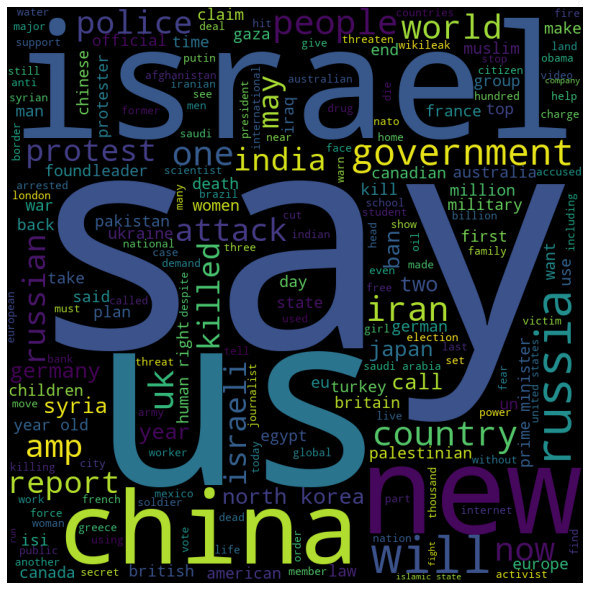

In [ ]:
# word cloud
from wordcloud import WordCloud, STOPWORDS
comment_words = ''
stopwords = set(STOPWORDS)
  
# iterate through the csv file
for val in mergedDf.headlines:
      
    # typecaste each val to string
    val = str(val)
  
    # split the value
    tokens = val.split()
      
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
      
    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='black',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
  
# plot the WordCloud image                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
  
plt.show()

# To find sentiments of news headlines

In [ ]:
# create a function get the sentiment text
def getSentiment(score):
    if score < 0:
        return "negative"
    elif score == 0:
        return "neutral"
    else:
        return "positive"

In [ ]:
# create a column to store the news sentiment
mergedDf['news_sentiment'] = mergedDf['polarity'].apply(getSentiment)
mergedDf.head()

,Close,Open,High,Low,Volume,headlines,polarity,subjectivity,compound,negative,neutral,positive,news_sentiment,news_sentiment_flag
Date,,,,,,,,,,,,,,
2008-08-08,11734.32031,11432.08984,11759.95996,11388.04004,212830000,b georgia downs two russian warplanes as cou...,-0.048568,0.267549,-0.9977,0.234,0.708,0.057,negative,0
2008-08-11,11782.34961,11729.66992,11867.11035,11675.53027,183190000,b why wont america and nato help us if they w...,0.109325,0.374806,-0.9783,0.186,0.713,0.101,positive,2
2008-08-12,11642.46973,11781.70020,11782.34961,11601.51953,173590000,b remember that adorable year old who sang a...,-0.035676,0.495171,-0.9753,0.135,0.813,0.052,negative,0
2008-08-13,11532.95996,11632.80957,11633.78027,11453.33984,182550000,b u s refuses israel weapons to attack iran ...,0.005842,0.364021,-0.9818,0.156,0.776,0.068,positive,2
2008-08-14,11615.92969,11532.07031,11718.28027,11450.88965,159790000,b all the experts admit that we should legalis...,0.049050,0.390095,-0.9874,0.201,0.698,0.101,positive,2


In [ ]:
# create a function get the sentiment text
def getSentiment(score):
    if score < 0:
        return 0 #negative
    elif score == 0:
        return 1  #neutral
    else:
        return 2 #positive

In [ ]:
# create a column to store the news sentiment
mergedDf['news_sentiment_flag'] = mergedDf['polarity'].apply(getSentiment)
mergedDf.head()

,Close,Open,High,Low,Volume,headlines,polarity,subjectivity,compound,negative,neutral,positive,news_sentiment,news_sentiment_flag
Date,,,,,,,,,,,,,,
2008-08-08,11734.32031,11432.08984,11759.95996,11388.04004,212830000,b georgia downs two russian warplanes as cou...,-0.048568,0.267549,-0.9977,0.234,0.708,0.057,negative,0
2008-08-11,11782.34961,11729.66992,11867.11035,11675.53027,183190000,b why wont america and nato help us if they w...,0.109325,0.374806,-0.9783,0.186,0.713,0.101,positive,2
2008-08-12,11642.46973,11781.70020,11782.34961,11601.51953,173590000,b remember that adorable year old who sang a...,-0.035676,0.495171,-0.9753,0.135,0.813,0.052,negative,0
2008-08-13,11532.95996,11632.80957,11633.78027,11453.33984,182550000,b u s refuses israel weapons to attack iran ...,0.005842,0.364021,-0.9818,0.156,0.776,0.068,positive,2
2008-08-14,11615.92969,11532.07031,11718.28027,11450.88965,159790000,b all the experts admit that we should legalis...,0.049050,0.390095,-0.9874,0.201,0.698,0.101,positive,2


In [ ]:
mergedDf.news_sentiment_flag.value_counts(normalize=True)*100

2    69.783811
0    30.216189
Name: news_sentiment_flag, dtype: float64

In [ ]:
# print percentage on top of each bar
def displaypercentage(ax,feature):
    
    total = len(mergedDf[feature])
    for p in ax.patches:
        percentage = '{:.2f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width()/2
        y = p.get_height()
        ax.annotate(percentage, (x, y),ha='center',va='bottom',fontsize=12,color='blue')


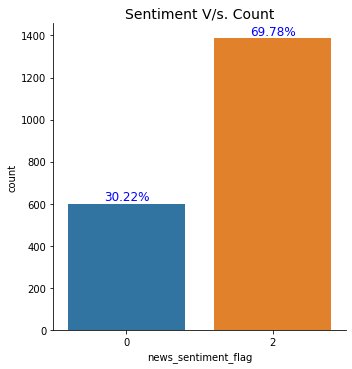

In [ ]:
# check the 'Converted' column
pl=sns.catplot(data=mergedDf,x='news_sentiment_flag',kind="count")
plt.title('Sentiment V/s. Count', fontsize = 14)
ax = pl.facet_axis(0,0)
displaypercentage(ax,'news_sentiment_flag')
plt.show()

### Negative Sentimets Count = 30.22%
### Neutral Sentimets Count = 0%
### Positive Sentimets Count = 69.78%

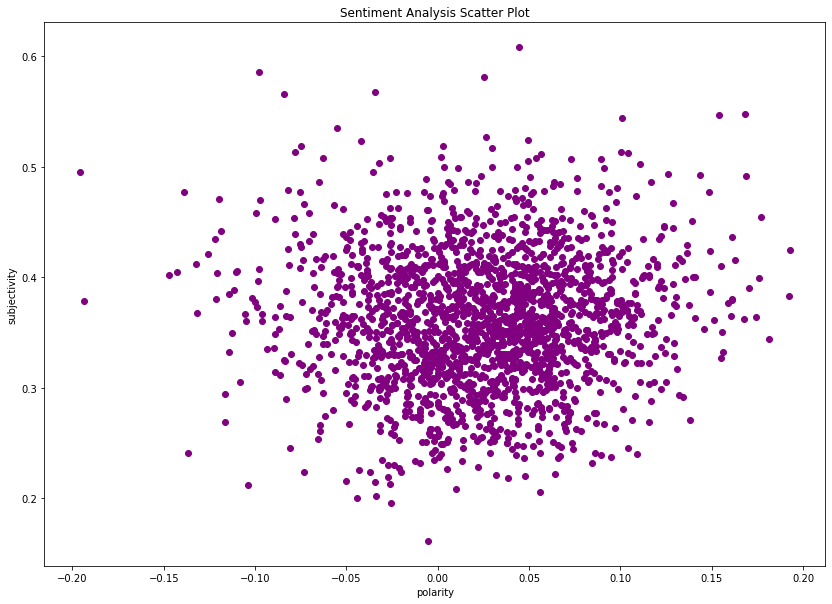

In [ ]:
# scatter plot to show the subjectivity and the polarity
plt.figure(figsize=(14,10))

for i in range(mergedDf.shape[0]):
    plt.scatter(mergedDf["polarity"].iloc[[i]].values[0], mergedDf["subjectivity"].iloc[[i]].values[0], color="Purple")

plt.title("Sentiment Analysis Scatter Plot")
plt.xlabel('polarity')
plt.ylabel('subjectivity')
plt.show()


# EDA for Stock Data

Text(0, 0.5, 'Close Price ($)')

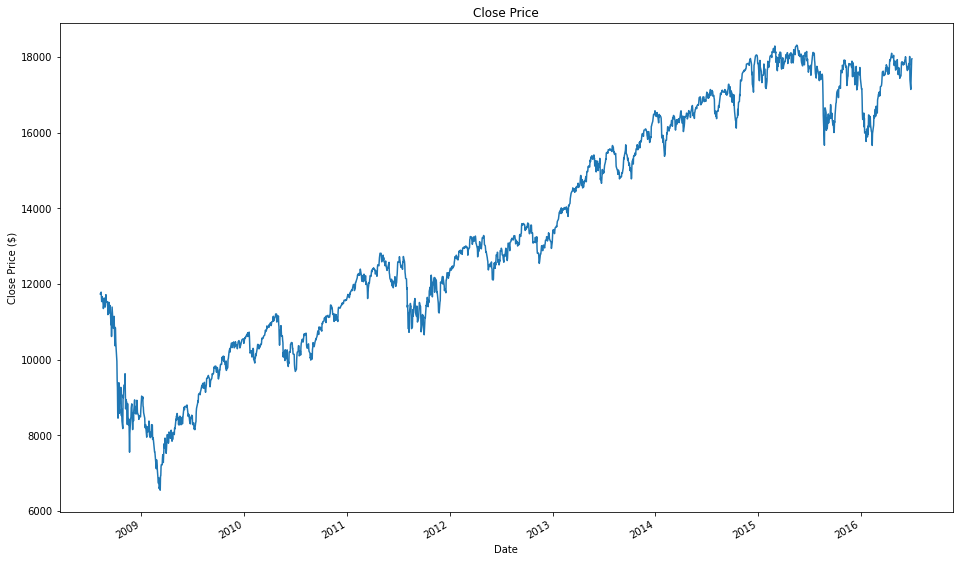

In [ ]:
# setting figure size
plt.figure(figsize=(16,10))

# plotting close price
mergedDf['Close'].plot()

# setting plot title, x and y labels
plt.title("Close Price")
plt.xlabel('Date')
plt.ylabel('Close Price ($)')

In [ ]:
# calculating 7 day rolling mean
mergedDf.rolling(7).mean().head(20)

,Close,Open,High,Low,Volume,polarity,subjectivity,compound,negative,neutral,positive,news_sentiment_flag
Date,,,,,,,,,,,,
2008-08-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-08-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-08-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-08-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-08-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-08-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-08-18,11635.331334,11625.600027,11737.399971,11514.738560,1.833257e+08,0.021579,0.403684,-0.984157,0.184714,0.738714,0.076429,1.428571
2008-08-19,11580.221263,11632.171456,11697.144251,11504.804269,1.774329e+08,0.025472,0.414040,-0.984114,0.188000,0.738143,0.073714,1.428571
2008-08-20,11528.089846,11577.352957,11638.149971,11449.811384,1.719600e+08,0.015337,0.391706,-0.986243,0.189286,0.743571,0.067000,1.428571


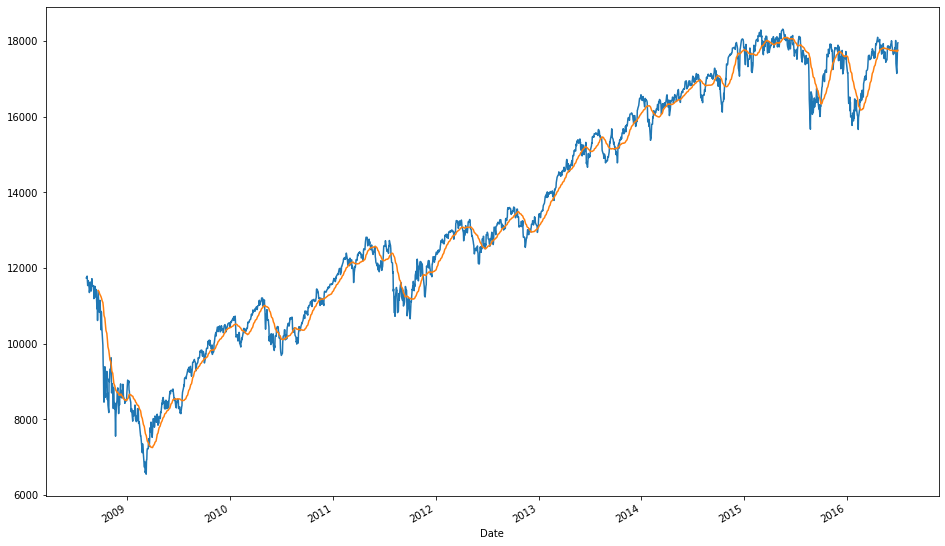

In [ ]:
# setting figure size
plt.figure(figsize=(16,10))

# plotting the close price and a 30-day rolling mean of close price
mergedDf['Close'].plot()
mergedDf.rolling(window=30).mean()['Close'].plot()

In [ ]:
mergedDf.head(3)

,Close,Open,High,Low,Volume,headlines,polarity,subjectivity,compound,negative,neutral,positive,news_sentiment,news_sentiment_flag
Date,,,,,,,,,,,,,,
2008-08-08,11734.32031,11432.08984,11759.95996,11388.04004,212830000,b georgia downs two russian warplanes as cou...,-0.048568,0.267549,-0.9977,0.234,0.708,0.057,negative,0
2008-08-11,11782.34961,11729.66992,11867.11035,11675.53027,183190000,b why wont america and nato help us if they w...,0.109325,0.374806,-0.9783,0.186,0.713,0.101,positive,2
2008-08-12,11642.46973,11781.70020,11782.34961,11601.51953,173590000,b remember that adorable year old who sang a...,-0.035676,0.495171,-0.9753,0.135,0.813,0.052,negative,0


In [ ]:
#Create a list of columns to keep in the completed data set and show the data.

keep_columns = ['Close','Open','polarity','subjectivity','compound','negative','neutral','positive']
df = mergedDf[keep_columns]
df.head()

,Close,Open,polarity,subjectivity,compound,negative,neutral,positive
Date,,,,,,,,
2008-08-08,11734.32031,11432.08984,-0.048568,0.267549,-0.9977,0.234,0.708,0.057
2008-08-11,11782.34961,11729.66992,0.109325,0.374806,-0.9783,0.186,0.713,0.101
2008-08-12,11642.46973,11781.70020,-0.035676,0.495171,-0.9753,0.135,0.813,0.052
2008-08-13,11532.95996,11632.80957,0.005842,0.364021,-0.9818,0.156,0.776,0.068
2008-08-14,11615.92969,11532.07031,0.049050,0.390095,-0.9874,0.201,0.698,0.101


In [ ]:
df.shape

(1989, 8)

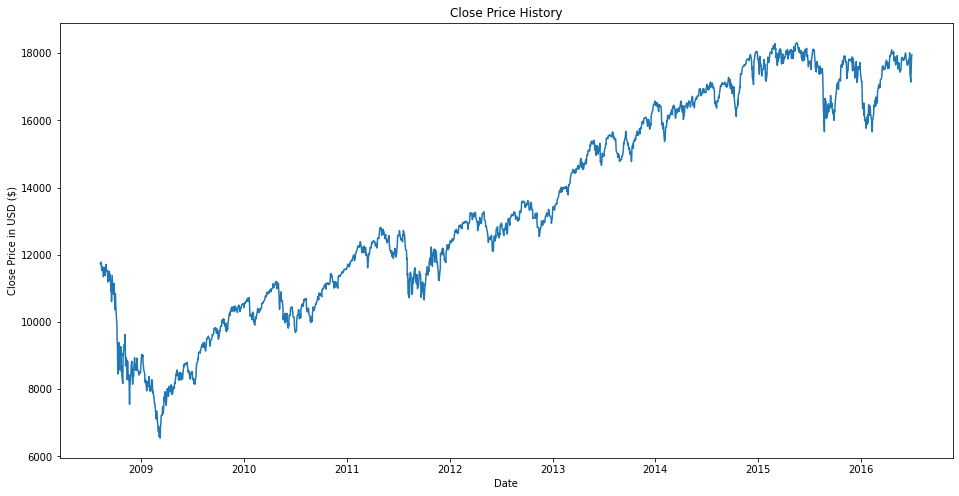

In [ ]:
#visualize the closing price history

plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date')
plt.ylabel('Close Price in USD ($)')
plt.show()

# Data Preparation for Modelling

In [ ]:
#convert dataframe to numpy array

dataset = df.values

#Get the number of rows to train LSTM model
train_data_len = math.ceil(len(dataset)*.8)

train_data_len

1592

In [ ]:
#Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.4408942 , 0.41511378, 0.37940404, ..., 0.64772727, 0.4244373 ,
        0.32894737],
       [0.44497647, 0.4404009 , 0.78553694, ..., 0.46590909, 0.44051447,
        0.61842105],
       [0.43308732, 0.44482222, 0.41256657, ..., 0.27272727, 0.76205788,
        0.29605263],
       ...,
       [0.9474974 , 0.92700227, 0.69951589, ..., 0.65909091, 0.24437299,
        0.69078947],
       [0.96749772, 0.94881899, 0.53325156, ..., 0.56818182, 0.47909968,
        0.36842105],
       [0.96914484, 0.96678972, 0.46345033, ..., 0.58712121, 0.45980707,
        0.36842105]])

In [ ]:
scaled_data[0]

array([0.4408942 , 0.41511378, 0.37940404, 0.23762114, 0.00095377,
       0.64772727, 0.4244373 , 0.32894737])

In [ ]:
#Create the training dataset
#Create the sclaed training dataset

train_data = scaled_data[0:train_data_len, :]

#Split the data into X_train and y_train dataset
x_train=[]
y_train=[]

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0:])
    y_train.append(train_data[i,0:])
    
    if i<=61:
        print(x_train)
        print(y_train)
        print()

[array([[4.40894198e-01, 4.15113783e-01, 3.79404039e-01, 2.37621142e-01,
        9.53767381e-04, 6.47727273e-01, 4.24437299e-01, 3.28947368e-01],
       [4.44976468e-01, 4.40400900e-01, 7.85536937e-01, 4.77569446e-01,
        1.06922343e-02, 4.65909091e-01, 4.40514469e-01, 6.18421053e-01],
       [4.33087320e-01, 4.44822217e-01, 4.12566566e-01, 7.46842064e-01,
        1.21981828e-02, 2.72727273e-01, 7.62057878e-01, 2.96052632e-01],
       [4.23779492e-01, 4.32170110e-01, 5.19358492e-01, 4.53442494e-01,
        8.93529441e-03, 3.52272727e-01, 6.43086817e-01, 4.01315789e-01],
       [4.30831538e-01, 4.23609707e-01, 6.30497291e-01, 5.11773525e-01,
        6.12419055e-03, 5.22727273e-01, 3.92282958e-01, 6.18421053e-01],
       [4.34568846e-01, 4.30334665e-01, 6.44055898e-01, 6.41645295e-01,
        1.10436223e-02, 4.01515152e-01, 5.40192926e-01, 5.26315789e-01],
       [4.19226261e-01, 4.34450931e-01, 5.47438676e-01, 7.26312551e-01,
        4.31705236e-03, 5.64393939e-01, 4.59807074e-01, 4

In [ ]:
# Note: y_train -> contains 61st value which model needs to predict on the basis of past 60 days values stored in x_train

In [ ]:
#Convert x_train and y_train dataset into numpy arrays so that can train for LSTM Model


x_train, y_train = np.array(x_train), np.array(y_train)

In [ ]:
#Reshape the data
x_train.shape #2D array

(1532, 60, 8)

In [ ]:
#LSTM required 3D
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 8))
x_train.shape

(1532, 60, 8)

In [ ]:
#Build LSTM Model

# setting the model architecture
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(x_train.shape[1],8)))
model.add(LSTM(50,return_sequences=False))
model.add(Dense(25))
model.add(Dense(8))

# printing the model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 60, 50)            11800     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_4 (Dense)             (None, 25)                1275      
                                                                 
 dense_5 (Dense)             (None, 8)                 208       
                                                                 
Total params: 33,483
Trainable params: 33,483
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Compile Model
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
#Train Model
model.fit(x_train,y_train,batch_size=1,epochs=1)

1532/1532 [==============================] - 45s 27ms/step - loss: 0.0143


In [ ]:
#Create the testing dataset
#Create new array containing scaled values from index 1532 to 1989
test_data=scaled_data[train_data_len-60: ,:]
#Create datasets --> x_test and y_test
x_test=[]
y_test=dataset[train_data_len: ,:]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0:8])

In [ ]:
x_test[0]

array([[8.94292931e-01, 8.89615554e-01, 6.54015606e-01, 4.95312416e-01,
        1.25345113e-01, 2.31060606e-01, 6.27009646e-01, 6.44736842e-01],
       [8.92617592e-01, 8.93130102e-01, 6.05878687e-01, 3.47648398e-01,
        7.37914763e-03, 3.52272727e-01, 5.91639871e-01, 5.06578947e-01],
       [8.87391204e-01, 8.91994877e-01, 6.30964145e-01, 4.36082331e-01,
        9.03569098e-03, 3.21969697e-01, 5.98070740e-01, 5.39473684e-01],
       [8.91099627e-01, 8.87296477e-01, 6.51974900e-01, 3.00966321e-01,
        1.11440189e-02, 1.70454545e-01, 8.32797428e-01, 3.28947368e-01],
       [8.99669721e-01, 8.90559583e-01, 6.44512398e-01, 3.83502876e-01,
        8.13212188e-03, 2.68939394e-01, 6.59163987e-01, 5.19736842e-01],
       [9.01784314e-01, 8.99384290e-01, 6.51856025e-01, 3.38349936e-01,
        2.66050901e-03, 3.82575758e-01, 6.39871383e-01, 3.55263158e-01],
       [9.11060766e-01, 9.02164759e-01, 4.97023897e-01, 4.50410192e-01,
        3.06209528e-03, 3.25757576e-01, 7.26688103e-01, 2.

In [ ]:
#Convert data to a numpy array
x_test=np.array(x_test)
x_test[0]

array([[8.94292931e-01, 8.89615554e-01, 6.54015606e-01, 4.95312416e-01,
        1.25345113e-01, 2.31060606e-01, 6.27009646e-01, 6.44736842e-01],
       [8.92617592e-01, 8.93130102e-01, 6.05878687e-01, 3.47648398e-01,
        7.37914763e-03, 3.52272727e-01, 5.91639871e-01, 5.06578947e-01],
       [8.87391204e-01, 8.91994877e-01, 6.30964145e-01, 4.36082331e-01,
        9.03569098e-03, 3.21969697e-01, 5.98070740e-01, 5.39473684e-01],
       [8.91099627e-01, 8.87296477e-01, 6.51974900e-01, 3.00966321e-01,
        1.11440189e-02, 1.70454545e-01, 8.32797428e-01, 3.28947368e-01],
       [8.99669721e-01, 8.90559583e-01, 6.44512398e-01, 3.83502876e-01,
        8.13212188e-03, 2.68939394e-01, 6.59163987e-01, 5.19736842e-01],
       [9.01784314e-01, 8.99384290e-01, 6.51856025e-01, 3.38349936e-01,
        2.66050901e-03, 3.82575758e-01, 6.39871383e-01, 3.55263158e-01],
       [9.11060766e-01, 9.02164759e-01, 4.97023897e-01, 4.50410192e-01,
        3.06209528e-03, 3.25757576e-01, 7.26688103e-01, 2.

In [ ]:
#Reshape the data
x_test=np.reshape(x_test, (x_test.shape[0],x_test.shape[1],8))
x_test

array([[[0.89429293, 0.88961555, 0.65401561, ..., 0.23106061,
         0.62700965, 0.64473684],
        [0.89261759, 0.8931301 , 0.60587869, ..., 0.35227273,
         0.59163987, 0.50657895],
        [0.8873912 , 0.89199488, 0.63096415, ..., 0.3219697 ,
         0.59807074, 0.53947368],
        ...,
        [0.95447732, 0.95854955, 0.63956681, ..., 0.45454545,
         0.57234727, 0.36184211],
        [0.9632106 , 0.95443502, 0.66476968, ..., 0.12878788,
         0.74276527, 0.58552632],
        [0.96602126, 0.96310688, 0.63279886, ..., 0.29545455,
         0.74598071, 0.28947368]],

       [[0.89261759, 0.8931301 , 0.60587869, ..., 0.35227273,
         0.59163987, 0.50657895],
        [0.8873912 , 0.89199488, 0.63096415, ..., 0.3219697 ,
         0.59807074, 0.53947368],
        [0.89109963, 0.88729648, 0.6519749 , ..., 0.17045455,
         0.83279743, 0.32894737],
        ...,
        [0.9632106 , 0.95443502, 0.66476968, ..., 0.12878788,
         0.74276527, 0.58552632],
        [0.9

In [ ]:
#Get the Models Predicted Price Values
predictions = model.predict(x_test)

In [ ]:
predictions[0]

array([ 0.9887396 ,  0.983262  ,  0.6543287 ,  0.44368774, -0.01473652,
        0.41675162,  0.5877681 ,  0.34741306], dtype=float32)

In [ ]:
predictions.shape

(397, 8)

In [ ]:
predictions = scaler.inverse_transform(predictions) #unscaling the values

In [ ]:
#Get root mean squared error (RMSE)
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

246.971827297177

In [ ]:
predictions[0]

array([ 1.7815047e+04,  1.7968564e+04,  2.1354830e-02,  3.4766662e-01,
       -1.0194976e+00,  1.8918657e-01,  7.6129997e-01,  5.7962086e-02],
      dtype=float32)

In [ ]:
predictions[0][0]

17815.047

In [ ]:
predictions[0][1]

17968.564

In [ ]:
len(predictions)

397

In [ ]:
train = df[:train_data_len]
train

,Close,Open,polarity,subjectivity,compound,negative,neutral,positive
Date,,,,,,,,
2008-08-08,11734.32031,11432.08984,-0.048568,0.267549,-0.9977,0.234,0.708,0.057
2008-08-11,11782.34961,11729.66992,0.109325,0.374806,-0.9783,0.186,0.713,0.101
2008-08-12,11642.46973,11781.70020,-0.035676,0.495171,-0.9753,0.135,0.813,0.052
2008-08-13,11532.95996,11632.80957,0.005842,0.364021,-0.9818,0.156,0.776,0.068
2008-08-14,11615.92969,11532.07031,0.049050,0.390095,-0.9874,0.201,0.698,0.101
...,...,...,...,...,...,...,...,...
2014-11-26,17827.75000,17812.25000,0.053438,0.386875,-0.9909,0.175,0.739,0.086
2014-11-28,17828.24023,17830.55078,0.050505,0.338792,-0.9955,0.183,0.746,0.071
2014-12-01,17776.80078,17827.26953,0.052576,0.409697,-0.9949,0.183,0.754,0.062


In [ ]:
valid = df[train_data_len:]
valid

,Close,Open,polarity,subjectivity,compound,negative,neutral,positive
Date,,,,,,,,
2014-12-04,17900.09961,17910.01953,-0.075678,0.430321,-0.9980,0.183,0.787,0.030
2014-12-05,17958.78906,17903.05078,-0.004446,0.257368,-0.9952,0.192,0.728,0.080
2014-12-08,17852.48047,17954.93945,0.009851,0.307413,-0.9940,0.170,0.752,0.078
2014-12-09,17801.19922,17847.36914,-0.028989,0.306339,-0.9938,0.174,0.751,0.075
2014-12-10,17533.15039,17797.99023,-0.074743,0.427416,-0.9981,0.235,0.696,0.069
...,...,...,...,...,...,...,...,...
2016-06-27,17140.24023,17355.21094,-0.014015,0.352311,-0.9808,0.162,0.746,0.092
2016-06-28,17409.72070,17190.50977,0.047722,0.349330,-0.9571,0.136,0.758,0.105
2016-06-29,17694.67969,17456.01953,0.075882,0.417835,-0.9972,0.237,0.652,0.112


In [ ]:
p_list=[] #prediction list
for i in range(len(predictions)):
    p_list.append(predictions[i][0])
    
p_list 

[17815.047,
 17839.188,
 17850.248,
 17857.197,
 17858.799,
 17837.553,
 17817.791,
 17838.059,
 17823.613,
 17755.588,
 17677.148,
 17615.545,
 17578.516,
 17580.516,
 17590.48,
 17634.748,
 17668.688,
 17705.588,
 17737.328,
 17763.13,
 17778.69,
 17778.156,
 17767.553,
 17735.105,
 17688.373,
 17656.773,
 17646.209,
 17622.717,
 17595.34,
 17584.404,
 17536.008,
 17518.47,
 17513.959,
 17521.713,
 17525.312,
 17527.611,
 17518.494,
 17518.098,
 17500.857,
 17501.33,
 17488.729,
 17499.742,
 17497.242,
 17525.81,
 17565.07,
 17590.98,
 17611.947,
 17650.748,
 17685.084,
 17700.838,
 17724.814,
 17754.094,
 17790.955,
 17819.502,
 17850.787,
 17874.273,
 17897.545,
 17924.195,
 17949.334,
 17957.465,
 17982.586,
 17999.037,
 17994.46,
 17986.04,
 17985.85,
 17974.121,
 17941.625,
 17914.736,
 17886.832,
 17863.605,
 17973.934,
 18021.781,
 18115.586,
 18152.79,
 18160.254,
 18266.387,
 18281.287,
 18254.387,
 18194.82,
 18125.904,
 18076.838,
 18025.88,
 17982.064,
 17947.291,
 17917.

In [ ]:
valid['Predicted Close Price'] = 0
for i in range(len(valid)):
    valid['Predicted Close Price'][i] = p_list[i]

In [ ]:
valid.head(3)

,Close,Open,polarity,subjectivity,compound,negative,neutral,positive,Predicted Close Price
Date,,,,,,,,,
2014-12-04,17900.09961,17910.01953,-0.075678,0.430321,-0.9980,0.183,0.787,0.030,17815
2014-12-05,17958.78906,17903.05078,-0.004446,0.257368,-0.9952,0.192,0.728,0.080,17839
2014-12-08,17852.48047,17954.93945,0.009851,0.307413,-0.9940,0.170,0.752,0.078,17850


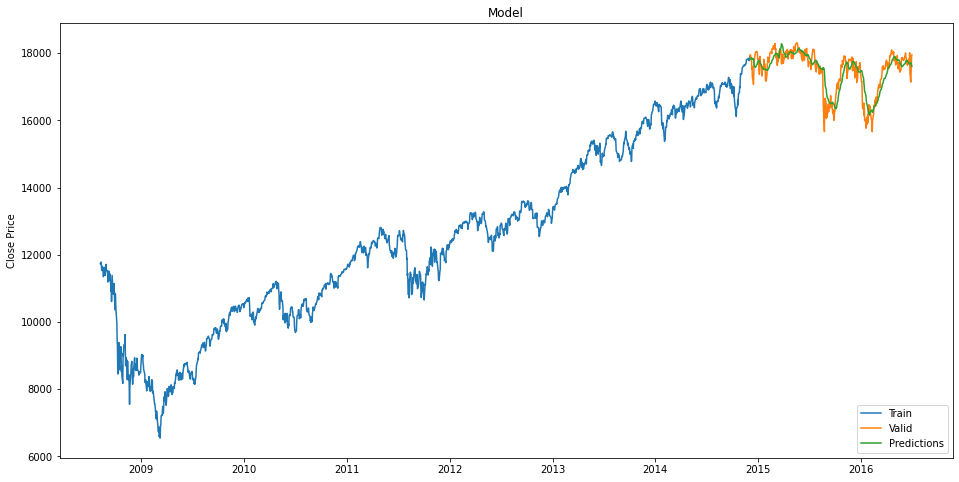

In [ ]:
#Visulaize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.ylabel('Close Price')
plt.plot(train[['Close']])
plt.plot(valid[['Close','Predicted Close Price']])
plt.legend(['Train','Valid','Predictions'], loc='lower right')
plt.show()

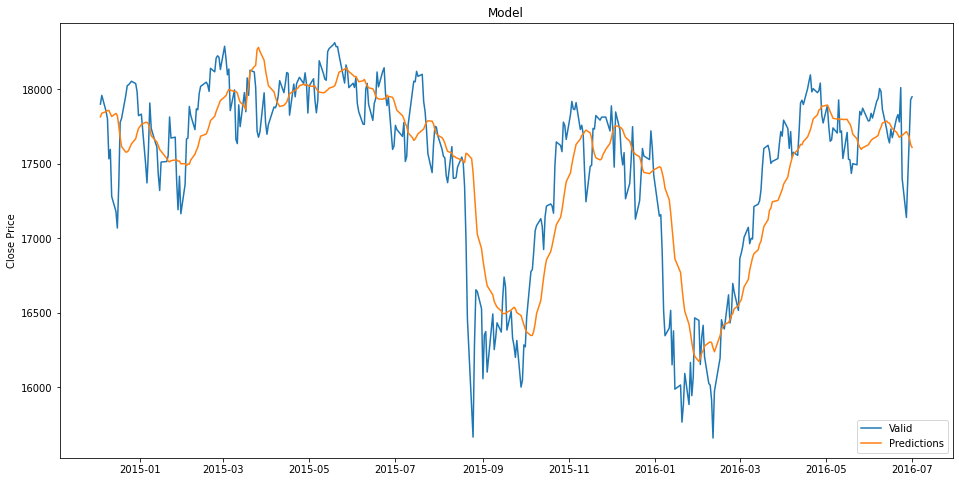

In [ ]:
#Visulaize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.ylabel('Close Price')
plt.plot(valid[['Close','Predicted Close Price']])
plt.legend(['Valid','Predictions'], loc='lower right')
plt.show()

In [ ]:
valid[['Close','Predicted Close Price']]

,Close,Predicted Close Price
Date,,
2014-12-04,17900.09961,17815
2014-12-05,17958.78906,17839
2014-12-08,17852.48047,17850
2014-12-09,17801.19922,17857
2014-12-10,17533.15039,17858
...,...,...
2016-06-27,17140.24023,17716
2016-06-28,17409.72070,17701
2016-06-29,17694.67969,17678


In [ ]:
valid['Price Up/Down'] = 0
for i in range(len(valid)):
    if (valid['Close'][i] > valid['Predicted Close Price'][i]):
        valid['Price Up/Down'][i] = 0 #price down
    else:
        valid['Price Up/Down'][i] = 1 #price up

In [ ]:
valid[['Close','Predicted Close Price','Price Up/Down']]

,Close,Predicted Close Price,Price Up/Down
Date,,,
2014-12-04,17900.09961,17815,0
2014-12-05,17958.78906,17839,0
2014-12-08,17852.48047,17850,0
2014-12-09,17801.19922,17857,1
2014-12-10,17533.15039,17858,1
...,...,...,...
2016-06-27,17140.24023,17716,1
2016-06-28,17409.72070,17701,1
2016-06-29,17694.67969,17678,0


In [ ]:
valid['Price Up/Down'].value_counts(normalize=True)

0    0.531486
1    0.468514
Name: Price Up/Down, dtype: float64

In [ ]:
# print percentage on top of each bar
def displaypercentage(ax,feature):
    
    total = len(valid[feature])
    for p in ax.patches:
        percentage = '{:.2f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width()/2
        y = p.get_height()
        ax.annotate(percentage, (x, y),ha='center',va='bottom',fontsize=12,color='blue')

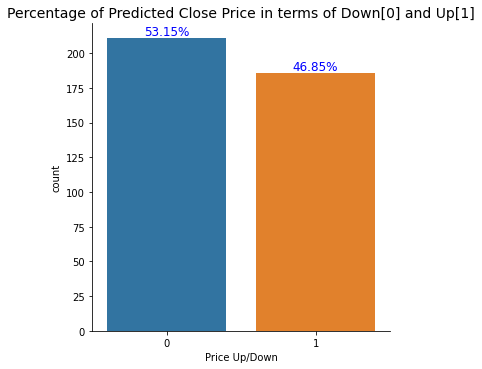

In [ ]:
# check the 'Converted' column
pl=sns.catplot(data=valid,x='Price Up/Down',kind="count")
plt.title('Percentage of Predicted Close Price in terms of Down[0] and Up[1]', fontsize = 14)
ax = pl.facet_axis(0,0)
displaypercentage(ax,'Price Up/Down')
plt.show()

In [ ]:
from tensorflow.keras import Model

In [ ]:
from tensorflow.keras.models import model_from_json

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model.save('stock_news_model.h5')

In [ ]:
#new_model = load_model('stock_news_model.h5')

In [ ]:
#new_model.summary()

In [ ]:
#new_model.get_weights()

In [ ]:
#new_model.optimizer